## GTZAN Audio classification using Spectograms

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1


In [2]:
import numpy as np
data = np.load('melspects.npz')

In [3]:
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

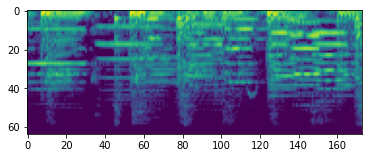

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
im = plt.imshow(data['x_tr'][0]) 

In [5]:
from tensorflow.keras.utils import to_categorical

x_tr = data['x_tr']
y_tr = data['y_tr']
x_te = data['x_te']
y_te = data['y_te']
x_cv = data['x_cv']
y_cv = data['y_cv']

tr_idx = np.random.permutation(len(x_tr))
te_idx = np.random.permutation(len(x_te))
cv_idx = np.random.permutation(len(x_cv))

x_tr = x_tr[tr_idx]
y_tr = y_tr[tr_idx]
x_te = x_te[te_idx]
y_te = y_te[te_idx]
x_cv = x_cv[cv_idx]
y_cv = y_cv[cv_idx]

x_tr = x_tr[:,:,:,np.newaxis]
x_te = x_te[:,:,:,np.newaxis]
x_cv = x_cv[:,:,:,np.newaxis]

input_shape = x_tr.shape[1:]

input_shape

(64, 173, 1)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
test_dataset = tf.data.Dataset.from_tensor_slices((x_te, y_te))

val_dataset = tf.data.Dataset.from_tensor_slices((x_cv, y_cv))

In [7]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

val_dataset = val_dataset.batch(BATCH_SIZE)

In [9]:
import tensorflow.keras.layers as layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


In [48]:
num_classes = 10

# model = keras.Sequential([
# #     data_augmentation,
#     layers.Input(shape=input_shape),
    
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes)
# ])

model = keras.Sequential()
model.add(layers.Conv2D(64, kernel_size=(4, 4),
                 activation='relu', #kernel_regularizer=regularizers.l2(0.04),
                 input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 4)))
model.add(layers.Conv2D(64, (3, 5), activation='relu'
                , kernel_regularizer=keras.regularizers.l2(0.04)
                ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (2, 2), activation='relu'
   # , kernel_regularizer=regularizers.l2(0.04)
    ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.04)))
model.add(layers.Dense(num_classes))

In [49]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 61, 170, 64)       1088      
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 170, 64)       256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 42, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 38, 64)        61504     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 19, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 19, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 18, 64)       

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs=50

early_stopping = EarlyStopping(monitor='val_loss', patience=15)
mcp_save = ModelCheckpoint('chkpoint', save_best_only=True, monitor='val_accuracy', mode='max')


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, mcp_save]
)

Epoch 1/50
125/125 [==============================] - 8s 61ms/step - loss: 1.4188 - accuracy: 0.7340 - val_loss: 1.7790 - val_accuracy: 0.6700
INFO:tensorflow:Assets written to: chkpoint/assets
Epoch 2/50
125/125 [==============================] - 8s 61ms/step - loss: 1.4035 - accuracy: 0.7418 - val_loss: 1.8377 - val_accuracy: 0.5900
Epoch 3/50
125/125 [==============================] - 8s 61ms/step - loss: 1.4071 - accuracy: 0.7440 - val_loss: 1.3219 - val_accuracy: 0.7800
INFO:tensorflow:Assets written to: chkpoint/assets
Epoch 4/50
125/125 [==============================] - 8s 61ms/step - loss: 1.3860 - accuracy: 0.7548 - val_loss: 1.4463 - val_accuracy: 0.7100
Epoch 5/50
125/125 [==============================] - 8s 61ms/step - loss: 1.4066 - accuracy: 0.7473 - val_loss: 1.6759 - val_accuracy: 0.6800
Epoch 6/50
125/125 [==============================] - 8s 61ms/step - loss: 1.4077 - accuracy: 0.7504 - val_loss: 1.5824 - val_accuracy: 0.6700
Epoch 7/50
125/125 [====================

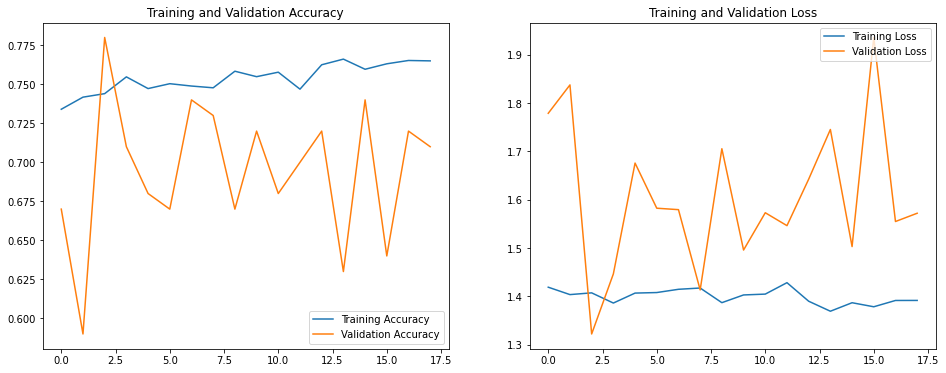

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
# The model weights (that are considered the best) are loaded into the model.
model = keras.models.load_model('chkpoint')

In [63]:
import numpy as np
confusion_mat = np.zeros((num_classes, num_classes))

for batch, labels in test_dataset:
    labels = tf.cast(labels, 'uint8')
    preds = np.argmax(model.predict(batch), axis=1)
    for idx in range(len(preds)):
        confusion_mat[labels[idx], preds[idx]] += 1
        
confusion_mat /= confusion_mat.sum(axis=1)
confusion_mat = np.around(confusion_mat, 2)

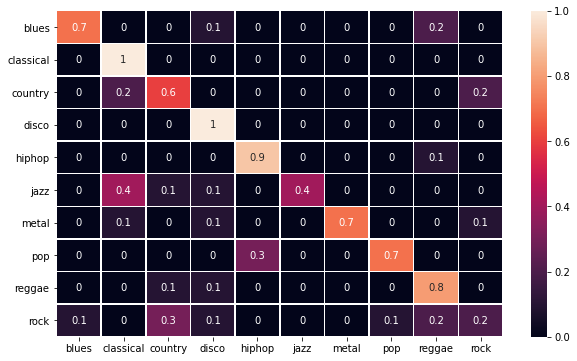

In [64]:
import seaborn as sns

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax = sns.heatmap(confusion_mat, ax=ax, annot=True, xticklabels=class_names, yticklabels=class_names, linewidth=0.5)

In [65]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 13ms/step - loss: 1.5579 - accuracy: 0.7000


[1.557946801185608, 0.699999988079071]